This notebook aims to go through a basic implementation of the gradient boosting algorithm using decision trees as our base estimator.  We will be using Scikit-Learn's DecisionTreeRegressor to build the trees, for more info on their package click <a href="http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html#sklearn.tree.DecisionTreeRegressor">here</a>  . Our algorithm will then be compared to Scikit_Learn's algorithm.  The two should be identical because we our using their decision trees as our base.

First, we will import any packages we will be using.  And preparing our data for modelling.  Splitting it into Test and Training sets. The dataset used also comes from Scikit-Learn, for documentation see <a href="http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_boston.html#sklearn.datasets.load_boston">here</a>

In [1]:
from sklearn.tree import DecisionTreeRegressor
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.utils import shuffle

In [2]:
boston = datasets.load_boston()
X, y = shuffle(boston.data, boston.target, random_state=13)
X = X.astype(np.float32)
offset = int(X.shape[0] * .9)
X_train, y_train = X[:offset], y[:offset]
X_test, y_test = X[offset:], y[offset:]
xi = X_train
yi = y_train

This implementation of the gradient boosting algorithm comes from Friedman<sup>[1]</sup>:
![Oops Something is wrong](gbt_algorithm.png "GBT Algorithm")

Although, this algorithm is not complete.  Later, a shrinkage parameter was added to 2.d for regularization:
![Oops Something is wrong](gbt_shrinkage.png "GBT Algorithm")
Basically, we will be initializing the algorithm with a very weak estimator (commonly the mean/median) then obtaining the residuals (Actual - Predicted).  We will then iteratively fit the residuals (after the initialization they are referred to as "pseudo-residuals" as they are no longer true residuals) with a shallow tree n times.  Each Epoch's prediction will be comprised of last Epoch's prediction plus this iteration's prediction on the psuedo-residuals multiplied by the shrinkage rate.  The shrinkage rate is a parameter which must be tuned along with the tree depth, which is the same for each tree that is constructed. 

In [3]:
ei = 0 # initialization of error
predf = 0 # initial prediction 0
count = 1 # initial count we will reference 
test_predictions = 0 # initial test set prediction 0
mse_list_adap = [] #Creating the mse data set
lr = .01#Setting the Learning rate
test_predictions_list = pd.DataFrame([])

In [4]:
for i in range(5000): # loop will make 5000 trees.
    tree = DecisionTreeRegressor(max_depth = 2) 
    tree.fit(xi,yi)
    predi =  tree.predict(xi)
    predicted =  tree.predict(X_test)

    #The first model is just the median, subsequent models will be trees built on the pseudo-residuals
    if count < 2:
        predf = np.median(yi)
    else:
        predf = predf + lr*predi  # final prediction will be previous prediction value + new prediction of pseudo-residual
    if count < 2:
        test_predictions = np.median(yi)
    else:
        test_predictions = test_predictions + lr*predicted
        test_predictions_list = pd.concat([test_predictions_list,pd.DataFrame(test_predictions)], 
                                          ignore_index = True, axis = 1)
    ei = y_train - predf  # needed originl y here as residual always from original y    
    yi = ei # update yi as residual to reloop
    count += 1
    test_mse = (np.mean((y_test - test_predictions)**2)) #Calculate MSE
    mse_list_adap.append(test_mse)

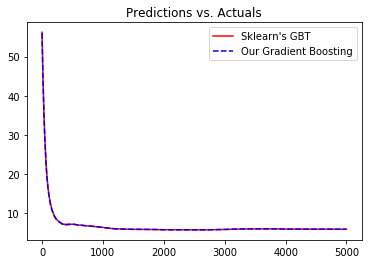

In [5]:
#List of the MSE's for each iteration
mse_list_adap = pd.DataFrame(mse_list_adap)

from sklearn.ensemble import GradientBoostingRegressor
n_est = 5000
rnd_reg = GradientBoostingRegressor(max_depth=2, n_estimators=n_est, subsample = 1, learning_rate=.01)
rnd_reg.fit(X_train,y_train)
predictions = rnd_reg.predict(X_test)
test_score = np.zeros((n_est,), dtype=np.float64)

for i, y_pred in enumerate(rnd_reg.staged_predict(X_test)):
    test_score[i] = (np.mean((y_test - y_pred)**2))

    

plt.plot(test_score, label = "Sklearn's GBT", color = 'red')
plt.plot(mse_list_adap, label = 'Our Gradient Boosting', color = 'blue', linestyle = 'dashed')
plt.legend()
plt.title('Predictions vs. Actuals')
plt.show()

In [36]:
from matplotlib import animation, rc

data = pd.DataFrame.transpose(test_predictions_list[test_predictions_list.columns[::50]])
def animate(nframe):
  plt.cla()
  plt.scatter(data.iloc[nframe], np.zeros_like(data.iloc[nframe]),label = 'Predicted', alpha = .8, s = 22**2)
  plt.title('Test Actuals vs. Predictions')
  plt.scatter(y_test, np.zeros_like(y_test),label = 'Actuals', alpha = .2, s= 22**2)
  plt.xlim(0,60)
  plt.ylim(-.5,1.5)
  plt.yticks([])
  plt.legend()
  plt.plot([y_test,data.iloc[nframe]], np.ones_like([y_test,data.iloc[nframe]]),marker = "o",markersize = 15,alpha = .2);
  

anim = animation.FuncAnimation(plt.figure(figsize=(8,6)), animate, frames=100);
rc('animation', html='html5')

In [37]:
anim

1: Friedman, J. H. "Greedy Function Approximation: A Gradient Boosting Machine." (February 1999)